# 1. Synchrotron and Synchrotron Self Compton

In this tutorial we will show how to compute the Spectral Energy Distribution (SED) produced by the Synchrotron and Synchrotron Self-Compton radiative processes.

We will also validate the results produced by `agnpy` by comparing them against the literature and against another open-source blazar modeling package: [jetset](https://jetset.readthedocs.io/en/1.1.2/).

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
import pkg_resources
import matplotlib.pyplot as plt
from IPython.core.display import Image, display

In [2]:
# import agnpy classes
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.utils.plot import plot_sed, load_mpl_rc

load_mpl_rc()

### 1.1. Synchrotron and Synchrotron Self-Compton emission in `agnpy`
Let us consider that the emission region is a blob of radius $R_b = 10^{16}\,\mathrm{cm}$, streaming with Lorentz factor $\Gamma=10$ along the jet axis, resulting in a Doppler boosting of $\delta_D=10$ (the jet is almost aligned with the observer's line of sight). The blob has a tangled magnetic field $B=1\,\mathrm{G}$. The galaxy hosting the active nucleus is at a distance of $d_L=10^{27}\,\mathrm{cm}$. 

The electron spectrum is described by a power law with index $-2.8$ with Lorentz factors in the range $10^2-10^7$ and a total energy content of $W_{\rm e} = 10^{48}\,{\rm erg}$.

In [3]:
# total energy content of the electron distribution
spectrum_norm = 1e48 * u.Unit("erg")

# EED parametrisation
spectrum_dict = {
    "type": "PowerLaw",
    "parameters": {"p": 2.8, "gamma_min": 1e2, "gamma_max": 1e7},
}

# blob attributes
R_b = 1e16 * u.cm
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10

# emission region
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

In [4]:
print(blob)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electron spectrum
 - power law
 - k_e: 9.27e+06 1 / cm3
 - p: 2.80
 - gamma_min: 1.00e+02
 - gamma_max: 1.00e+07


### 1.1.1. Synchrotron radiation
To initialize the object that will compute the synchrotron radiation, **we simply pass the `Blob` instance to the `Synchrotron` class**. Synchrotron self absorption can also be considered.

In [5]:
synch = Synchrotron(blob)
synch_ssa = Synchrotron(blob, ssa=True)

Every class defining a radiative process has a `.sed_flux` function computing the SED over an array of frequencies.

In [6]:
# let us define a grid of frequencies over which to calculate the synchrotron SED
nu_synch = np.logspace(8, 23) * u.Hz

# compute a synchrotron, and a self-absorbed synchrotron SED
sed_synch = synch.sed_flux(nu_synch)
sed_synch_ssa = synch_ssa.sed_flux(nu_synch)

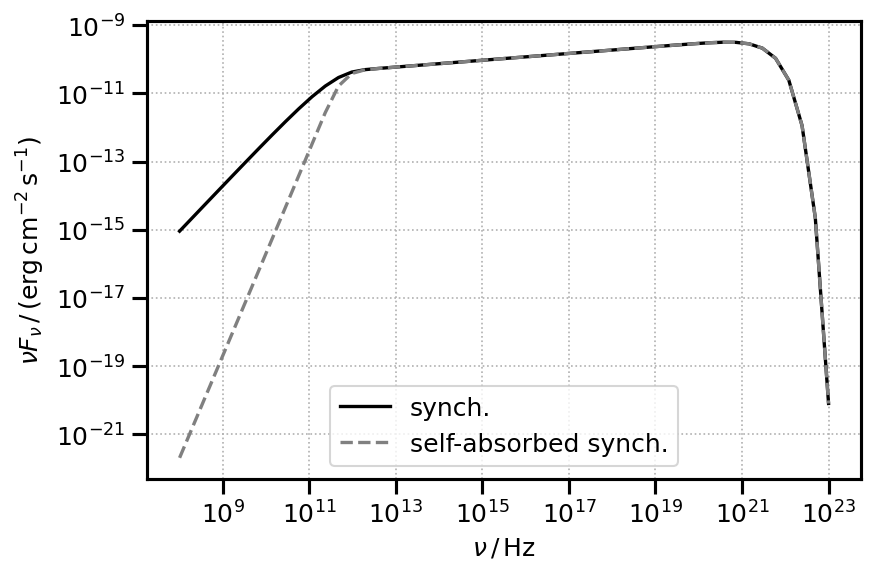

In [7]:
plot_sed(nu_synch, sed_synch, color="k", label="synch.")
plot_sed(nu_synch, sed_synch_ssa, ls="--", color="gray", label="self-absorbed synch.")
plt.show()

### 1.1.2. Synchrotron Self-Compton Radiation
Similarly to the synchrotron case, to initialize the object that will compute the synchrotron self-Compton (SSC) radiation, we simply pass the `Blob` instance to the `SynchrotronSelfCompton` class.       
We examine also the case produced by Compton scattering of a self-absorbed synchrotron spectrum.

In [8]:
# simple ssc
ssc = SynchrotronSelfCompton(blob)
# ssc over a self-absorbed synchrotron spectrum
ssc_ssa = SynchrotronSelfCompton(blob, ssa=True)

In [9]:
nu_ssc = np.logspace(15, 30) * u.Hz

sed_ssc = ssc.sed_flux(nu_ssc)
sed_ssc_ssa = ssc_ssa.sed_flux(nu_ssc)

/home/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: divide by zero encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)
/home/cosimo/work/agnpy/agnpy/synchrotron/synchrotron.py:66: RuntimeWarning: invalid value encountered in true_divide
  u = 1 / 2 + np.exp(-tau) / tau - (1 - np.exp(-tau)) / np.power(tau, 2)


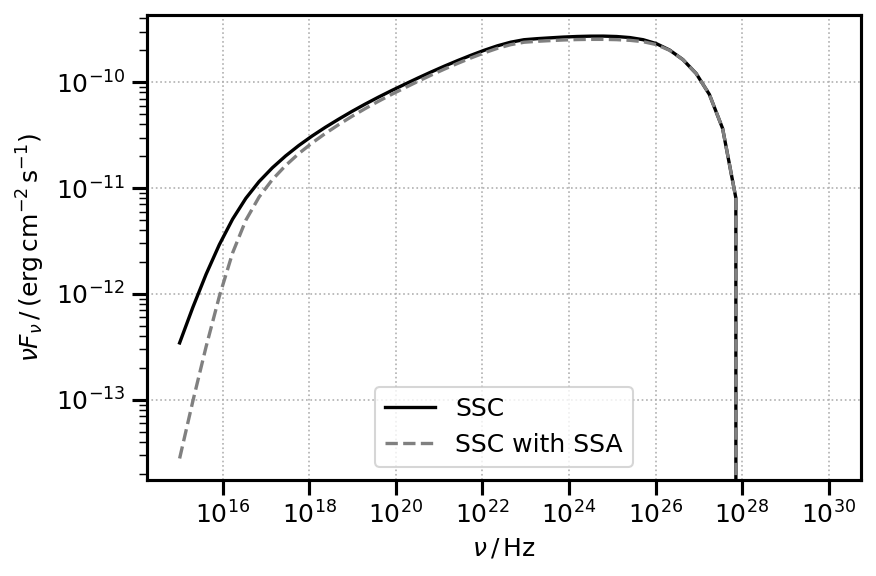

In [10]:
plot_sed(nu_ssc, sed_ssc, color="k", label="SSC")
plot_sed(nu_ssc, sed_ssc_ssa, ls="--", color="gray", label="SSC with SSA")
plt.show()

## 1.2. Validation: compare the result of `agnpy` against the literature and `JetSet`

In order to validate `agnpy` we can compare the results of its calculations against the literature and against other software.

For what concerns the literature, we choose to reproduce Figure 7.4 of [Dermer and Menon (2009)](https://ui.adsabs.harvard.edu/abs/2009herb.book.....D/abstract). The figure, reported here, depicts two complete synchrotron and SSC SEDs, generated by the same emission regions distinguished only by the different maximum Lorentz factor of their electron distributions ($\gamma_{\rm max} = 10^5$ and $\gamma_{\rm max} = 10^7$).

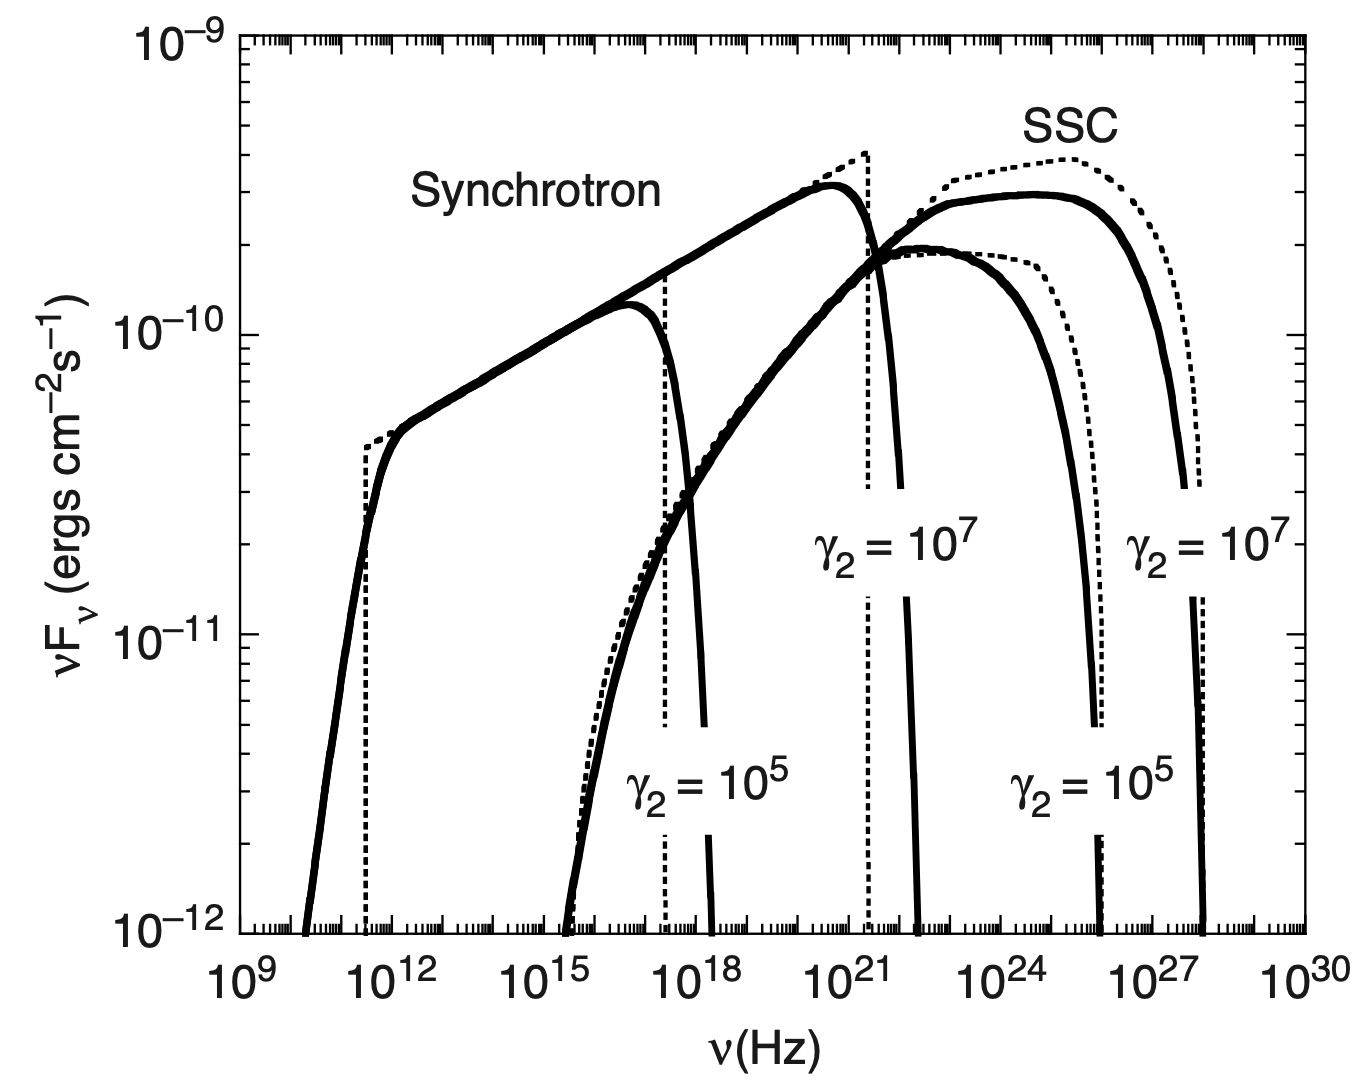

In [11]:
url = "https://raw.githubusercontent.com/cosimoNigro/agnpy/master/docs/tutorials/figures/figure_7_4_dermer_2009.png"
Image(url, width=800, height=600)

In the figure, the model with $\gamma_{\rm max} = 10^7$ has the same parameter values we used in the definition of our blob.

To make a comparison against another software, we use the same emission region parameters to compute synchrotron and SSC emission with `JetSet`.

In [12]:
# generate synchrotron and SSC SEDs with JetSet
from jetset.jet_model import Jet

jet = Jet(
    name="ssc",
    electron_distribution="pl",
    electron_distribution_log_values=False,
    beaming_expr="bulk_theta",
)
jet.set_par("N", val=blob.n_e_tot.value)
jet.set_par("p", val=blob.n_e.p)
jet.set_par("gmin", val=blob.n_e.gamma_min)
jet.set_par("gmax", val=blob.n_e.gamma_max)
jet.set_par("R", val=blob.R_b.value)
jet.set_par("B", val=blob.B.value)
jet.set_par("BulkFactor", val=blob.Gamma)
jet.set_par("theta", val=blob.theta_s.value)
jet.set_par("z_cosm", val=blob.z)

# remove SSA
jet.spectral_components.Sync.state = "on"

# - synchrotron SED with jetset
jet.set_nu_grid(nu_synch[0].value, nu_synch[-1].value, len(nu_synch))
jet.eval()

nu_synch_jetset = jet.spectral_components.Sync.SED.nu
sed_synch_jetset = jet.spectral_components.Sync.SED.nuFnu

# - SSC SED with jetset
jet.set_nu_grid(nu_ssc[0].value, nu_ssc[-1].value, len(nu_ssc))
jet.eval()

nu_ssc_jetset = jet.spectral_components.SSC.SED.nu
sed_ssc_jetset = jet.spectral_components.SSC.SED.nuFnu

The numerical values of the SED in the reference figure are stored in the `agnpy` resources.

In [13]:
# load the SED from the reference figure
synch_dermer = pkg_resources.resource_filename(
    "agnpy",
    "data/reference_seds/dermer_menon_2009/figure_7_4/synchrotron_gamma_max_1e7.txt",
)

ssc_dermer = pkg_resources.resource_filename(
    "agnpy", "data/reference_seds/dermer_menon_2009/figure_7_4/ssc_gamma_max_1e7.txt"
)

data_synch_dermer = np.loadtxt(synch_dermer, delimiter=",")
data_ssc_dermer = np.loadtxt(ssc_dermer, delimiter=",")

nu_synch_dermer = data_synch_dermer[:, 0] * u.Hz
sed_synch_dermer = data_synch_dermer[:, 1] * u.Unit("erg cm-2 s-1")

nu_ssc_dermer = data_ssc_dermer[:, 0] * u.Hz
sed_ssc_dermer = data_ssc_dermer[:, 1] * u.Unit("erg cm-2 s-1")

We then produce a final validation plot.

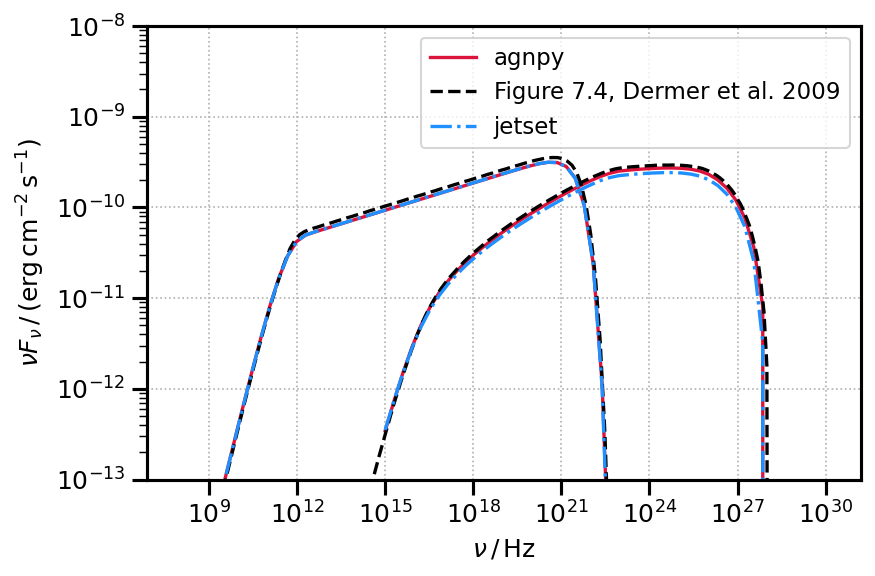

In [14]:
plot_sed(nu_synch, sed_synch, color="crimson", label="agnpy",)
plot_sed(nu_ssc, sed_ssc, color="crimson")

plot_sed(nu_synch_dermer, sed_synch_dermer, color="k", ls="--", label="Figure 7.4, Dermer et al. 2009")
plot_sed(nu_ssc_dermer, sed_ssc_dermer, color="k", ls="--")

plot_sed(nu_synch_jetset, sed_synch_jetset, color="dodgerblue", ls="-.", label="jetset")
plot_sed(nu_ssc_jetset, sed_ssc_jetset, color="dodgerblue", ls="-.")

plt.legend(fontsize=11)
plt.ylim([1e-13, 1e-8])
plt.show()

We get an excellent agreement, further validation examples are provided in the [agnpy release paper](https://arxiv.org/abs/2112.14573).

## 1.3. Exercises 

### 1.3.1. Equipartition
Determine if the jet is at equipartition.